In [145]:
import pandas as pd
import numpy as np
import csv
import math
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

In [146]:
def mse(pre, act):
    er = 0
    for i in range(len(pre)):
        er +=(pre[i][0]-act[i])**2
    er = er/len(pre)
    er = er**(1/2)
    er = er/(sum(act)/len(act))
    return (1-er)*100

In [147]:
def add_data(filename, data):
    to_add = []
    with open('data.csv', mode='r')as csvfile:
        csvFile = csv.reader(csvfile)
        for lines in csvFile:
            to_add.append(lines)

    # data rows of csv file
    rows = [data]

    for i in rows:
        to_add.append(i)

    # writing to csv file
    with open(filename, 'w') as csvfile:
        # creating a csv writer object
        csvwriter = csv.writer(csvfile)

        # writing the data rows
        for j in to_add:
            if (j == []):
                continue
            else:
                csvwriter.writerow(j)


In [148]:
data = pd.read_csv("data.csv")
data = data.sample(frac=1)

In [149]:
data

,Retirement,Debut Age (yrs),Longest Gap b/w innings,Time of best moving avg,No of innings,Time of worst moving avg,time of better score than 20% best scores
78,27.997260,24.202740,489,0.500000,30,0.966667,0.866667
76,31.358904,22.372603,498,0.262295,61,0.967213,0.573770
21,35.073973,23.904110,343,0.515789,190,0.463158,0.889474
9,38.660274,23.424658,328,0.366038,265,0.328302,0.939623
29,30.435616,22.564384,322,0.783784,111,0.270270,0.765766
...,...,...,...,...,...,...,...
68,29.882192,22.561644,970,0.531915,47,0.276596,0.851064
42,32.983562,24.273973,385,0.244444,90,0.522222,0.800000
3,22.147945,19.619178,346,0.392857,28,0.928571,1.000000
14,29.619178,22.375342,371,0.483871,62,0.322581,0.822581


In [150]:
data.columns

Index(['Retirement', 'Debut Age (yrs)', 'Longest Gap b/w innings',
       'Time of best moving avg', 'No of innings', 'Time of worst moving avg',
       'time of better score than 20% best scores'],
      dtype='object')

In [151]:
# data["Age (yrs)"] = np.random.permutation(data["Age (yrs)"].values)
# data

In [152]:
#Set Target Variable
output_var = pd.DataFrame(data['Retirement'])
#Selecting the Features
features = [
	"Debut Age (yrs)",	"Longest Gap b/w innings",	"Time of best moving avg",	"No of innings",	"Time of worst moving avg",	"time of better score than 20% best scores"
    ]


In [153]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(data[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=data.index)
feature_transform.head()
# feature_transform

,Debut Age (yrs),Longest Gap b/w innings,Time of best moving avg,No of innings,Time of worst moving avg,time of better score than 20% best scores
78,0.436782,0.059046,0.435627,0.029740,0.970622,0.687179
76,0.299672,0.060842,0.164353,0.144981,0.971205,0.000000
21,0.414409,0.029922,0.453646,0.624535,0.433765,0.740688
9,0.378489,0.026930,0.282746,0.903346,0.289977,0.858345
29,0.314039,0.025733,0.759486,0.330855,0.228102,0.450450


In [154]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=8)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [155]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [156]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(5))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy']
             )


In [157]:
history=lstm.fit(X_train, y_train, epochs=750, batch_size=8, verbose=0, shuffle=False)

In [158]:
y_pred= lstm.predict(X_test)
print(lstm.summary())
mean_sqaure_error = mse(y_pred, y_test)

1/1 [==============================] - 0s 134ms/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 32)                4992      
                                                                 
 dense_18 (Dense)            (None, 5)                 165       
                                                                 
 dense_19 (Dense)            (None, 1)                 6         
                                                                 
Total params: 5,163
Trainable params: 5,163
Non-trainable params: 0
_________________________________________________________________
None


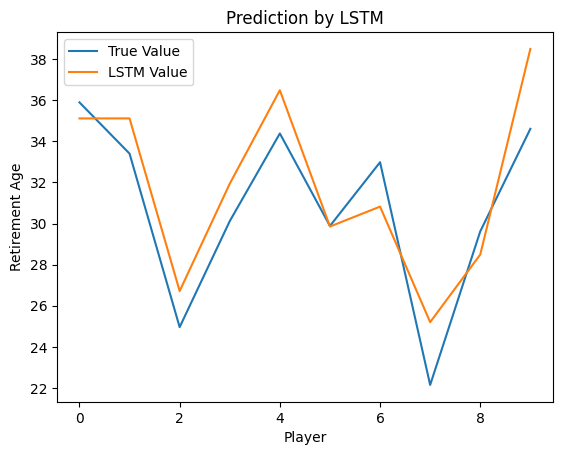

In [159]:
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Player')
plt.ylabel('Retirement Age')
plt.legend()
plt.show()

In [160]:
c = 0
for j in range(len(y_test)):
    if(y_pred[j][0] > y_test[j]):
        c = c + y_test[j]/y_pred[j][0]
    elif(y_pred[j][0] <= y_test[j]):
        c = c + y_pred[j][0]/y_test[j]
accuracy2 = c/len(y_test)
c = 0
for j in range(len(y_test)):
    c = c + y_pred[j][0]/y_test[j]
accuracy3 = c/len(y_test)

print(mean_sqaure_error)
print(accuracy2)
print(accuracy3)

93.13264127697853
0.942244726648067
1.0367160851768493
